# Training Data Set Generation

Open driving dataset - https://github.com/weisongwen/UrbanLoco.<br><br>
Kinematic, vehicle-based data is collected in ROS (Robot Operating System) bags https://www.ros.org/. <br>
Rosbags are a form of sqlite database, containing common robotics messages such as navigation (position, velocity, attitude) in universally defined schemas https://pypi.org/project/rosbags/. <br>
This notebook goes through the bag provided in the open source to get the IMU and GNSS data. Then, features and labels are created to perform vehicle state classification using supervised learning. 


In [1]:
# Imports 
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Rosbags python API - https://www.ros.org/
from rosbags.rosbag1 import Reader
from rosbags.rosbag1 import Writer
from rosbags.typesys import Stores, get_types_from_msg,  get_typestore

In [2]:
# This is used for plotting latitude, longitude position data into matplotlib charts - https://geospace-code.github.io/pymap3d/
import pymap3d as pm

In [3]:
# The rosbags must be placed in a folder called data in the project workspace
path_bagfiles = 'data/'
path_bag = os.path.join(path_bagfiles, '20190331WH.bag')
path_msgs = r'msgs'

In [4]:
# Open rosbag data base
with Reader(path_bag) as reader:
    # Print all the topics (tables) and their schema (messages)
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

/imu/data sensor_msgs/msg/Imu
/navsat/origin geometry_msgs/msg/Pose
/novatel_data/inscov novatel_msgs/msg/INSCOV
/velodyne_points sensor_msgs/msg/PointCloud2
/camera/image_color sensor_msgs/msg/Image
/novatel_data/inspvax novatel_msgs/msg/INSPVAX
/navsat/odom nav_msgs/msg/Odometry
/navsat/fix sensor_msgs/msg/NavSatFix
/novatel_data/bestpos novatel_msgs/msg/BESTPOS
/GNSS_ nlosExclusion/msg/GNSS_Raw_Array
/novatel_data/corrimudata novatel_msgs/msg/CORRIMUDATA


Data collected for multiple sensors including IMU, GNSS, LiDAR, and camera. <br>
Out of these, only IMU data (/imu/data sensor_msgs/msg/Imu) and novatel GNSS data (/novatel_data/inspvax novatel_msgs/msg/INSPVAX) are needed. 

In [5]:
# Novatel messages are not inbuilt to ROS, so their custom definitions must be added to our parser
msg_register_map = {
                    'novatel_msgs/CommonHeader': 'novatel_header.msg',
                    'novatel_msgs/msg/INSPVAX': 'inspvax.msg' ,
                    }
# This is the rosbag message parser
typestore_ros = get_typestore(Stores.ROS1_NOETIC)
# Add the custom schemas here
for topic, msg_def in msg_register_map.items():
    _msg_txt = Path(os.path.join(path_msgs, msg_def)).read_text()
    typestore_ros.register(get_types_from_msg(_msg_txt, topic))

In [6]:
# Initial look at data from the IMU
# Each unit of data contains timestamp, acceleration, and angular veloctiy. 
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

sensor_msgs__msg__Imu(header=std_msgs__msg__Header(seq=126143, stamp=builtin_interfaces__msg__Time(sec=1554023987, nanosec=31778097, __msgtype__='builtin_interfaces/msg/Time'), frame_id='/imu', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=-0.011451647616922855, y=-0.004325337242335081, z=-0.912064790725708, w=0.4098632037639618, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([0.01745, 0.     , 0.     , 0.     , 0.01745, 0.     , 0.     ,
       0.     , 0.15708]), angular_velocity=geometry_msgs__msg__Vector3(x=-0.009423699229955673, y=0.009598053060472012, z=-0.007060869596898556, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0.0004, 0.    , 0.    , 0.    , 0.0004, 0.    , 0.    , 0.    ,
       0.0004]), linear_acceleration=geometry_msgs__msg__Vector3(x=-0.00018585583893582225, y=-0.0755721852183342, z=9.926544189453125, __msgtype__='geometry_msgs/msg/Vector3'), linear_acceleration_covariance

In [7]:
# Initial look at data from GNSS
# Each unit contains time stamp, position (lat, long, alt), velocity (east, north, up), and also attitude angles (azimuth/heading, roll, pitch)
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

novatel_msgs__msg__INSPVAX(header=novatel_msgs__msg__CommonHeader(id=1465, msg_type=0, port_addr=64, length=126, sequence=0, idle_time=133, time_status=180, gps_week=2047, gps_week_seconds=33604000, receiver_status=2048, reserved=19988, software_version=13754, RECEIVER_STATUS_ERROR=1, RECEIVER_STATUS_TEMPERATURE_WARNING=2, RECEIVER_STATUS_VOLTAGE_SUPPLY_WARNING=4, RECEIVER_STATUS_ANTENNA_UNPOWERED=8, RECEIVER_STATUS_LNA_FAILURE=16, RECEIVER_STATUS_ANTENNA_OPEN=32, RECEIVER_STATUS_ANTENNA_SHORTED=64, RECEIVER_STATUS_CPU_OVERLOADED=128, RECEIVER_STATUS_COM1_BUFFER_OVERRUN=256, RECEIVER_STATUS_COM2_BUFFER_OVERRUN=512, RECEIVER_STATUS_COM3_BUFFER_OVERRUN=1024, RECEIVER_STATUS_LINK_OVERLOAD=2048, RECEIVER_STATUS_AUX_TRANSMIT_OVERRUN=8192, RECEIVER_STATUS_AGC_OUT_OF_RANGE=16384, RECEIVER_STATUS_INS_RESET=65536, RECEIVER_STATUS_ALMANAC_INVALID=262144, RECEIVER_STATUS_POSITION_SOLUTION_INVALID=524288, RECEIVER_STATUS_POSITION_NOT_FIXED=1048576, RECEIVER_STATUS_CLOCK_STEERING_DISABLED=2097152, 

The timestamp from GNSS is in GPS Time, which is a time standard like UTC, however, it runs 18 seconds behind. <br><br>

In [8]:
SECONDS_IN_GPS_WEEK = 604800.0
def gps2utc(gps_week, gps_seconds):
    '''
    To time associate IMU data with GNSS data, GNSS data's time stamps which are in 
    GPS time must be converted to UTC time, this funciton does that. 

    Code from the open-soruce data set repo https://github.com/IPNL-POLYU/UrbanNavDataset/blob/master/docs/GETTING_STARTED.md
    '''
    utctime = (gps_week * SECONDS_IN_GPS_WEEK + gps_seconds-18) + 315964800
    return utctime

In [9]:
# Taking a closer look at the the time stamp of GNSS data, converted to UTC time
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(f"UTC time in seconds (s) for {i}th GNSS data - {gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)}")
            i+=1 
            if i > 2: break

UTC time in seconds (s) for 0th GNSS data - 1554023986.0
UTC time in seconds (s) for 1th GNSS data - 1554023987.0
UTC time in seconds (s) for 2th GNSS data - 1554023988.0


In [10]:
# Closer look at UTC timestamps for IMU data
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(f"UTC time in seconds (s) for {i}th IMU data - {msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9}")
            i+=1 
            if i > 2: break

UTC time in seconds (s) for 0th IMU data - 1554023987.031778
UTC time in seconds (s) for 1th IMU data - 1554023987.041805
UTC time in seconds (s) for 2th IMU data - 1554023987.051786


Now we know all the data we must extract from the ROSBAGS.<br>
1. IMU - UTC Time (seconds, nanoseconds), accelerometer (x,y,z), and gyroscope (x,y,z)
1. GNSS - UTC Time (seconds, nanoseconds), Velocity (East, North, Up) and Heading/Azimuth.

In [11]:
# Define the headers for the pandas dataframes to be created 
header_imu = ['time','time_sec', 'time_ns', 
            'gx', 'gy', 'gz', 
            'ax', 'ay', 'az']

header_gnss = ['time', 'time_sec', 'time_ns', 've', 'vn', 'vu', 'azimuth', 'lat', 'lon', 'alt']

In [12]:
# initially load IMU and GNSS data into these arrays
imu = []
gnss = []

In [13]:
# Parse through data bag and extract the IMU and GNSS data 
with Reader(path_bag) as reader:

    for connection, timestamp, rawdata in reader.messages():
        
        if connection.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = msg.header.stamp.sec + msg.header.stamp.nanosec*1e-9
            imu.append([
                t, msg.header.stamp.sec, msg.header.stamp.nanosec,
                msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z,
                msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z])
        elif connection.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)
            _sec = int(t)
            _nanosec = (t -_sec) * 1e9
            gnss.append([
                t,_sec, _nanosec,
                msg.east_velocity, msg.north_velocity, msg.up_velocity,
                msg.azimuth, msg.latitude, msg.longitude, msg.altitude])


In [14]:
# Load IMU and GNSS data into the dataframe
df_imu = pd.DataFrame(imu, columns=header_imu)
df_gnss = pd.DataFrame(gnss, columns=header_gnss)

In [15]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az
0,1.554024e+09,1554023987,31778097,-0.009424,0.009598,-0.007061,-0.000186,-0.075572,9.926544
1,1.554024e+09,1554023987,41805028,-0.013273,-0.001445,-0.003336,0.242389,-0.133454,9.471782
2,1.554024e+09,1554023987,51785945,-0.006775,0.001513,0.002580,0.418169,0.123401,9.704272
3,1.554024e+09,1554023987,61822891,-0.008774,0.004429,-0.002785,0.161406,0.251727,10.097395
4,1.554024e+09,1554023987,72040081,-0.009878,0.006944,-0.003777,-0.024371,0.079656,9.859933


In [16]:
df_imu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26103 entries, 0 to 26102
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      26103 non-null  float64
 1   time_sec  26103 non-null  int64  
 2   time_ns   26103 non-null  int64  
 3   gx        26103 non-null  float64
 4   gy        26103 non-null  float64
 5   gz        26103 non-null  float64
 6   ax        26103 non-null  float64
 7   ay        26103 non-null  float64
 8   az        26103 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.8 MB


In [17]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt
0,1.554024e+09,1554023986,0.0,-0.019538,0.109664,0.009960,121.450816,22.305098,114.189441,5.669012
1,1.554024e+09,1554023987,0.0,-0.028548,0.110861,0.006722,121.449261,22.305101,114.189441,5.700238
2,1.554024e+09,1554023988,0.0,-0.019205,0.121036,0.013710,121.446610,22.305102,114.189442,5.710292
3,1.554024e+09,1554023989,0.0,-0.027814,0.091362,0.003086,121.431515,22.305101,114.189442,5.658451
4,1.554024e+09,1554023990,0.0,-0.020974,0.033997,0.010066,121.398764,22.305096,114.189443,5.416831


In [18]:
df_gnss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      261 non-null    float64
 1   time_sec  261 non-null    int64  
 2   time_ns   261 non-null    float64
 3   ve        261 non-null    float64
 4   vn        261 non-null    float64
 5   vu        261 non-null    float64
 6   azimuth   261 non-null    float64
 7   lat       261 non-null    float64
 8   lon       261 non-null    float64
 9   alt       261 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 20.5 KB


In [19]:
# All time measurements are large, will not look good in plots, therefore define an intial time to track smalle relative time value 
# Earliest time instance observed 
t0 = min(df_imu['time'].iloc[0], df_gnss['time'].iloc[0])
# Keep track of relative time - for plots 
df_imu['t_rel'] = df_imu['time'] - t0
df_gnss['t_rel'] = df_gnss['time'] - t0

The IMU data has a sample of 100 Hz, its not neccessary to conisder. But if we incldue this the model can be generalized to IMU data at different rates. <br>
To account for this, all IMU measurements are multiplied by sampling interval of 0.01 seconds. 

In [20]:
T = 1/100 # sample rate
# Multiple acceleration and rotation rates by sampling time
for param in ['a', 'g']:
    for dir in ['x', 'y', 'z']:
        # Create new columns for (imu_measurement * sampling rate)
        df_imu[param+dir+'dt'] = df_imu[param+dir] * T

IMU data has a lot of sign connotations. For example, gyroscope data positive means turn in one direction, while negative means turn in the other direction. <br>
We do not care about these differences between turn directions, we only want turn versus straight line. However, if the sign connotations are ignored, there are more classes introduced in the model than we are look for. Therefore, to make data sign agnostive, the magnitude of accleration and gyroscope at each measurement instance is considered. This is a common approach in motion classification using IMU[1]. <br> 
[1]I. Skog, P. Handel, J. -O. Nilsson and J. Rantakokko, "Zero-Velocity Detection—An Algorithm Evaluation," in IEEE Transactions on Biomedical Engineering, vol. 57, no. 11, pp. 2657-2666, Nov. 2010, doi: 10.1109/TBME.2010.2060723.

In [21]:
df_imu['adt'] = np.sqrt(np.square(df_imu['axdt']) + np.square(df_imu['aydt']) + np.square(df_imu['azdt']))
df_imu['gdt'] = np.sqrt(np.square(df_imu['gxdt']) + np.square(df_imu['gydt']) + np.square(df_imu['gzdt']))
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.554024e+09,1554023987,31778097,-0.009424,0.009598,-0.007061,-0.000186,-0.075572,9.926544,1.031778,-0.000002,-0.000756,0.099265,-0.000094,0.000096,-0.000071,0.099268,0.000152
1,1.554024e+09,1554023987,41805028,-0.013273,-0.001445,-0.003336,0.242389,-0.133454,9.471782,1.041805,0.002424,-0.001335,0.094718,-0.000133,-0.000014,-0.000033,0.094758,0.000138
2,1.554024e+09,1554023987,51785945,-0.006775,0.001513,0.002580,0.418169,0.123401,9.704272,1.051786,0.004182,0.001234,0.097043,-0.000068,0.000015,0.000026,0.097141,0.000074
3,1.554024e+09,1554023987,61822891,-0.008774,0.004429,-0.002785,0.161406,0.251727,10.097395,1.061823,0.001614,0.002517,0.100974,-0.000088,0.000044,-0.000028,0.101018,0.000102
4,1.554024e+09,1554023987,72040081,-0.009878,0.006944,-0.003777,-0.024371,0.079656,9.859933,1.072040,-0.000244,0.000797,0.098599,-0.000099,0.000069,-0.000038,0.098603,0.000127


### An initial look at the IMU data

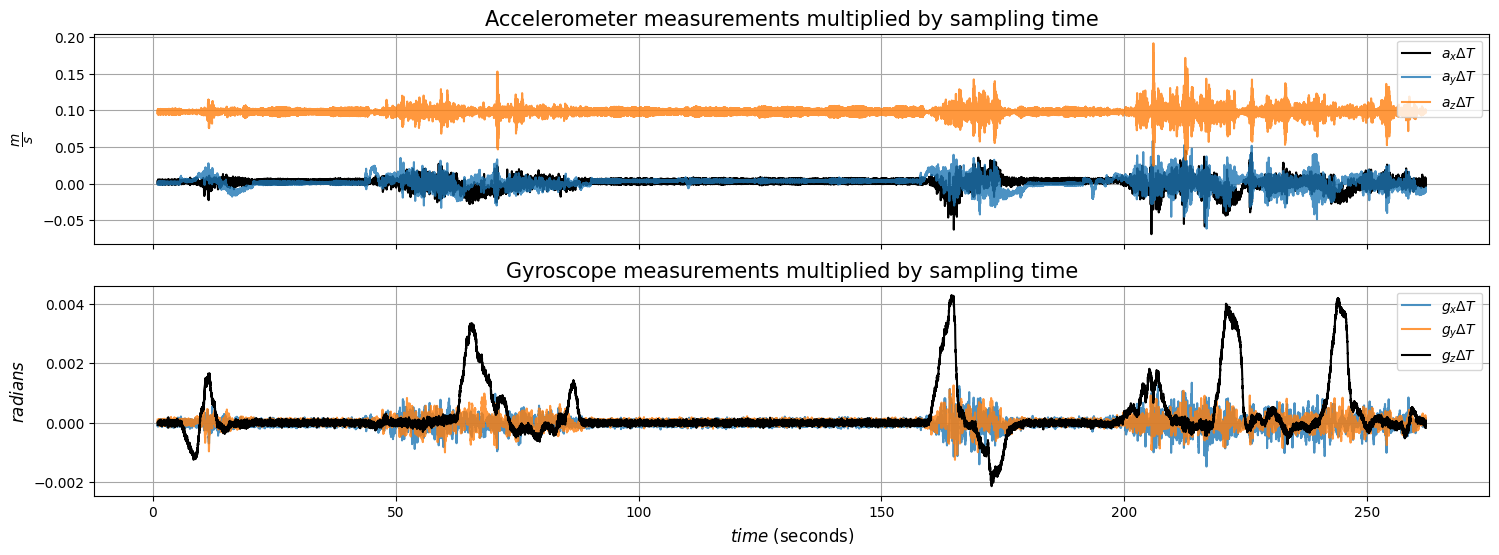

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,6), sharex='col')

ax1.plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
ax1.plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
ax1.plot(df_imu['t_rel'], df_imu['azdt'],  label=r'$a_z \Delta T$', alpha=0.8)


ax2.plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

ax1.legend()
ax1.set_title("Accelerometer measurements multiplied by sampling time", size=15)
ax1.grid(True, which='both',ls='-',color='0.65')
ax1.set_ylabel(r'$\frac{m}{s}$', size=14)

ax2.legend()
ax2.set_title("Gyroscope measurements multiplied by sampling time", size=15)
ax2.grid(True, which='both',ls='-',color='0.65')

ax2.set_xlabel(r'$time$ (seconds)', size=12)
ax2.set_ylabel(r'$radians$', size=12)   
print()

### Visualize GNSS data

In [23]:
# Keep a copy of gnss_index, this is for later join operations
df_gnss['gnss_index'] = df_gnss.index.to_numpy()
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index
0,1.554024e+09,1554023986,0.0,-0.019538,0.109664,0.009960,121.450816,22.305098,114.189441,5.669012,0.0,0
1,1.554024e+09,1554023987,0.0,-0.028548,0.110861,0.006722,121.449261,22.305101,114.189441,5.700238,1.0,1
2,1.554024e+09,1554023988,0.0,-0.019205,0.121036,0.013710,121.446610,22.305102,114.189442,5.710292,2.0,2
3,1.554024e+09,1554023989,0.0,-0.027814,0.091362,0.003086,121.431515,22.305101,114.189442,5.658451,3.0,3
4,1.554024e+09,1554023990,0.0,-0.020974,0.033997,0.010066,121.398764,22.305096,114.189443,5.416831,4.0,4


In [24]:
# Center of the trajectory (in time)
_N_gnss = df_gnss.index.size
# Latitude, Longitude, and Height measurements are converted to East, North, and Up displacements from the center of the trajectory
df_gnss['E'], df_gnss['N'], df_gnss['U'] = zip(*df_gnss.apply(
                                                        lambda x : pm.geodetic2enu(x['lat'], x['lon'], x['alt'],
                                                                                   df_gnss['lat'].iloc[int(_N_gnss/2)], df_gnss['lon'].iloc[int(_N_gnss/2)], df_gnss['alt'].iloc[int(_N_gnss/2)]
                                                                                   ), axis=1
))

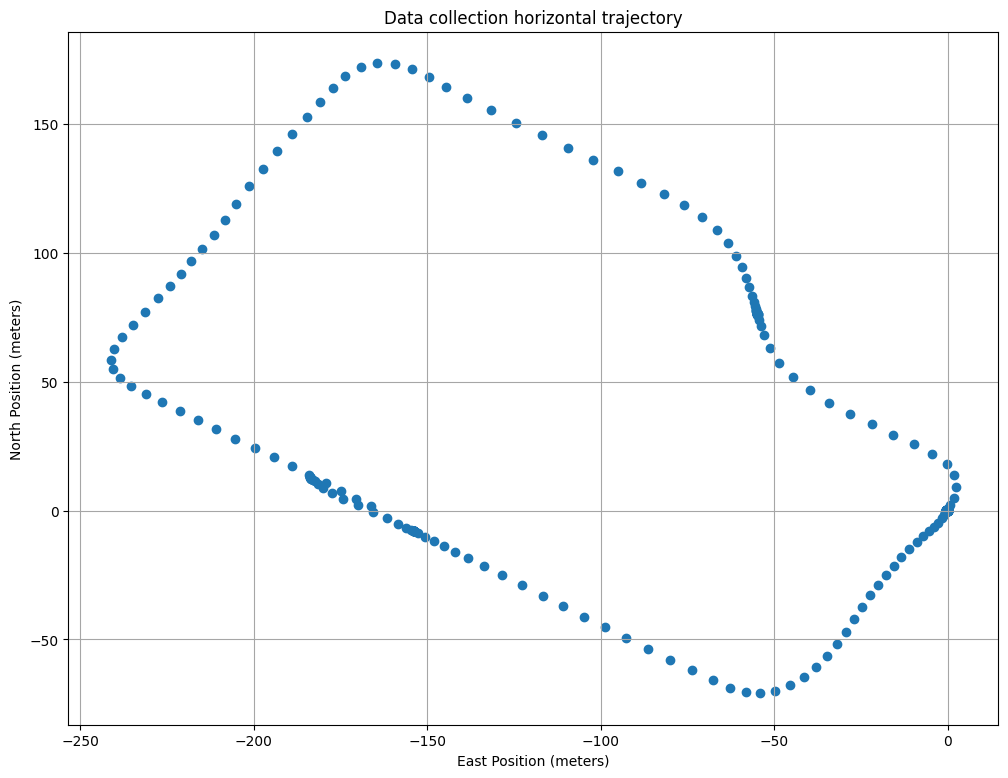

In [25]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(df_gnss['E'], df_gnss['N'])

ax.grid(True, which='both',ls='-',color='0.65')
ax.set_title("Data collection horizontal trajectory")
ax.set_xlabel("East Position (meters)")
ax.set_ylabel("North Position (meters)")
print()

In [26]:
# Simplify the GNSS velocity components into a single speed column which can be used for rest labeling.
# speed is in meters per seconds
df_gnss['speed'] = np.sqrt(np.square(df_gnss['ve']) + np.square(df_gnss['vn']) + np.square(df_gnss['vu']))
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed
0,1.554024e+09,1554023986,0.0,-0.019538,0.109664,0.009960,121.450816,22.305098,114.189441,5.669012,0.0,0,-183.743348,12.767607,-0.159950,0.111835
1,1.554024e+09,1554023987,0.0,-0.028548,0.110861,0.006722,121.449261,22.305101,114.189441,5.700238,1.0,1,-183.692797,13.110181,-0.128723,0.114675
2,1.554024e+09,1554023988,0.0,-0.019205,0.121036,0.013710,121.446610,22.305102,114.189442,5.710292,2.0,2,-183.649811,13.195655,-0.118668,0.123314
3,1.554024e+09,1554023989,0.0,-0.027814,0.091362,0.003086,121.431515,22.305101,114.189442,5.658451,3.0,3,-183.658284,13.106710,-0.170509,0.095552
4,1.554024e+09,1554023990,0.0,-0.020974,0.033997,0.010066,121.398764,22.305096,114.189443,5.416831,4.0,4,-183.571915,12.576330,-0.412126,0.041195


The cluttered scattered points are multiple GNSS measurements near the same position, implying rest.

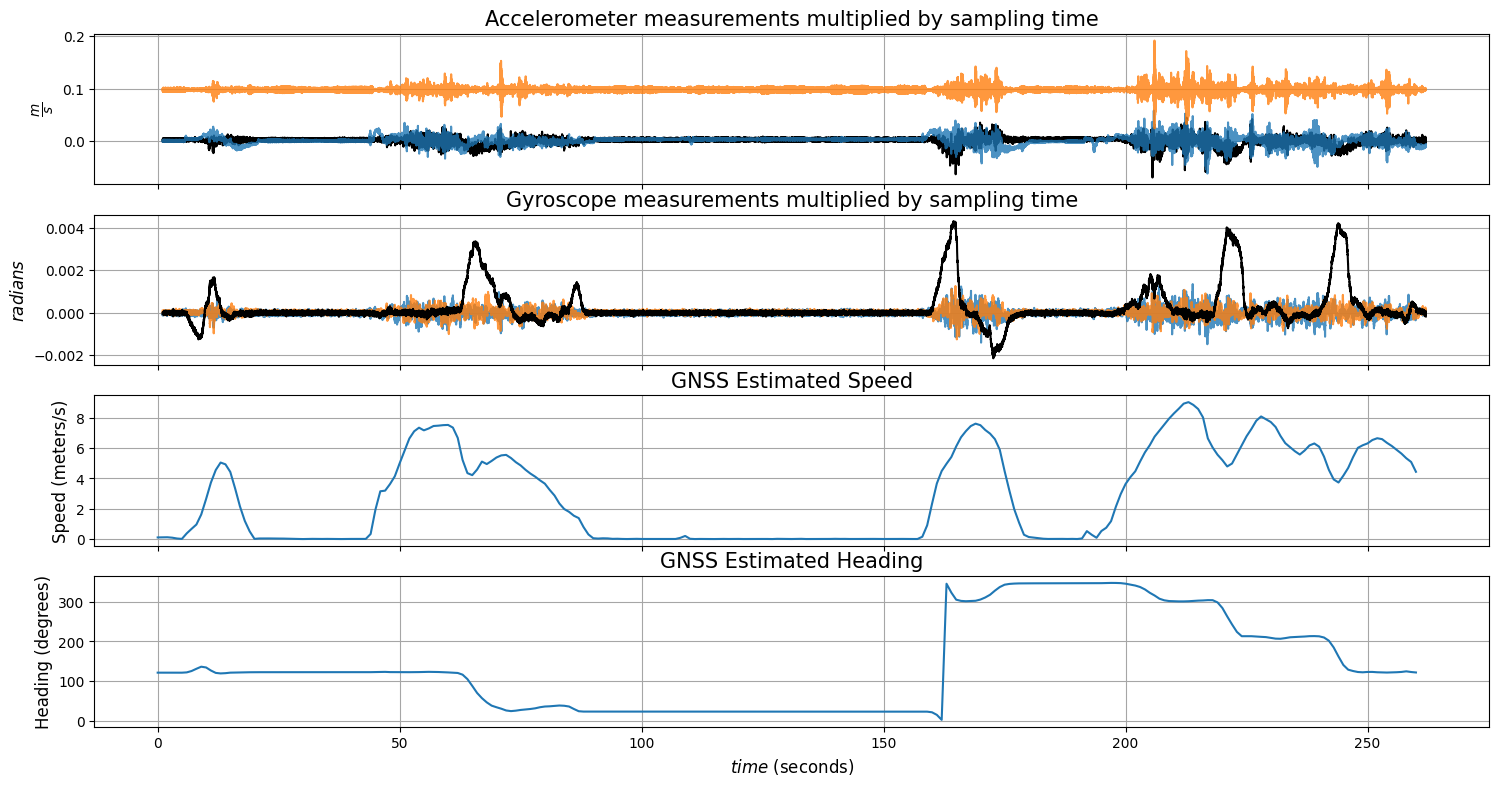

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9),sharex='col')

axs[0].plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(df_imu['t_rel'],  df_imu['azdt'], label=r'$a_z \Delta T$', alpha=0.8)

axs[1].plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[2].plot(df_gnss['t_rel'], df_gnss['speed'],  label=r'$Ve$')

axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  label=r'$Ve$')


axs[0].set_title("Accelerometer measurements multiplied by sampling time", size=15)
axs[0].set_ylabel(r'$\frac{m}{s}$', size=14)

axs[1].set_title("Gyroscope measurements multiplied by sampling time", size=15)
axs[1].set_ylabel(r'$radians$', size=12)   

axs[2].set_title("GNSS Estimated Speed", size=15)
axs[2].set_ylabel("Speed (meters/s)", size=12)

axs[3].set_title("GNSS Estimated Heading", size=15)
axs[3].set_ylabel("Heading (degrees)", size=12)

axs[3].set_xlabel(r'$time$ (seconds)', size=12)

print()

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')



Correlation between speed with gyroscope, and accelerometer acitivity. Also some correlation between Azimuth and gyroscope data. Infact, accelerometer and gyroscope measure the cause of velocity changes and gyroscope measures cause of accelerometer change. <br><br>
In theory, accelerometer measurements related to change in speed, while gyroscope measurements related to change in heading. <br><br>
Therefore, it makes more sense to make labels based on changes in speed and changes in in heading. 

In [28]:
# Shift the columns up by 1, so that each row has the next rows speed and azimuth
df_gnss['speed_next'] = df_gnss['speed'].shift(-1)
df_gnss['azimuth_next'] = df_gnss['azimuth'].shift(-1)

In [29]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
0,1.554024e+09,1554023986,0.0,-0.019538,0.109664,0.009960,121.450816,22.305098,114.189441,5.669012,0.0,0,-183.743348,12.767607,-0.159950,0.111835,0.114675,121.449261
1,1.554024e+09,1554023987,0.0,-0.028548,0.110861,0.006722,121.449261,22.305101,114.189441,5.700238,1.0,1,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.446610
2,1.554024e+09,1554023988,0.0,-0.019205,0.121036,0.013710,121.446610,22.305102,114.189442,5.710292,2.0,2,-183.649811,13.195655,-0.118668,0.123314,0.095552,121.431515
3,1.554024e+09,1554023989,0.0,-0.027814,0.091362,0.003086,121.431515,22.305101,114.189442,5.658451,3.0,3,-183.658284,13.106710,-0.170509,0.095552,0.041195,121.398764
4,1.554024e+09,1554023990,0.0,-0.020974,0.033997,0.010066,121.398764,22.305096,114.189443,5.416831,4.0,4,-183.571915,12.576330,-0.412126,0.041195,0.015098,121.389027


In [30]:
# The last row should have missing entries
df_gnss.tail(3)

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
258,1.554024e+09,1554024244,0.0,4.286532,-3.172057,0.010579,124.774219,22.305050,114.189528,7.149259,258.0,258,-174.731296,7.513850,1.320558,5.332580,5.088415,123.085157
259,1.554024e+09,1554024245,0.0,4.236195,-2.818972,0.004177,123.085157,22.305023,114.189570,7.200643,259.0,259,-170.473999,4.497618,1.372060,5.088415,4.438930,121.917375
260,1.554024e+09,1554024246,0.0,3.732015,-2.403353,0.007875,121.917375,22.304999,114.189610,7.215507,260.0,260,-166.305867,1.826463,1.387036,4.438930,NaN,NaN


In [31]:
# Remove the last row 
df_gnss = df_gnss[df_gnss['speed_next'].notna()]

In [32]:
def classify_motion(row: pd.Series) -> tuple:
    '''
    Algorithm implementation of motion classification for 1 second interval using GNSS measurements. 
    Input/s:    
        row -> a row in the GNSS dataframe
    Output/s:
        tuple
            (1,0,0) -> Rest
            (0,1,0) -> Straight Motion
            (0,0,1) -> Turning Motion
    '''
    speed = row['speed']
    speed_next = row['speed_next']
    
    # If speed now and a second later is very small, that means vehicle was in
    # rest for the second
    if speed < 0.1 and speed_next < 0.1:
        return (1,0,0)
    else:
        # If speed was not small for now and next second, vehicle moved. 
        azim = row['azimuth']
        azim_next = row['azimuth_next']

        # If the azimuth or heading angle did not change significantly, that means the vehicle 
        # that means the vehicle moves in a straight line
        if abs(azim - azim_next) < 2:
            return (0,1,0)
        
        # Else vehicle is turning
        return (0,0,1)       

In [33]:
# Apply the classification to the GNSS dataset
df_gnss['rest'], df_gnss['straight'], df_gnss['turn'] = zip(*df_gnss.apply(lambda x: classify_motion(x), axis=1))

In [34]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023986,0.0,-0.019538,0.109664,0.009960,121.450816,22.305098,114.189441,5.669012,...,0,-183.743348,12.767607,-0.159950,0.111835,0.114675,121.449261,0,1,0
1,1.554024e+09,1554023987,0.0,-0.028548,0.110861,0.006722,121.449261,22.305101,114.189441,5.700238,...,1,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.446610,0,1,0
2,1.554024e+09,1554023988,0.0,-0.019205,0.121036,0.013710,121.446610,22.305102,114.189442,5.710292,...,2,-183.649811,13.195655,-0.118668,0.123314,0.095552,121.431515,0,1,0
3,1.554024e+09,1554023989,0.0,-0.027814,0.091362,0.003086,121.431515,22.305101,114.189442,5.658451,...,3,-183.658284,13.106710,-0.170509,0.095552,0.041195,121.398764,1,0,0
4,1.554024e+09,1554023990,0.0,-0.020974,0.033997,0.010066,121.398764,22.305096,114.189443,5.416831,...,4,-183.571915,12.576330,-0.412126,0.041195,0.015098,121.389027,1,0,0


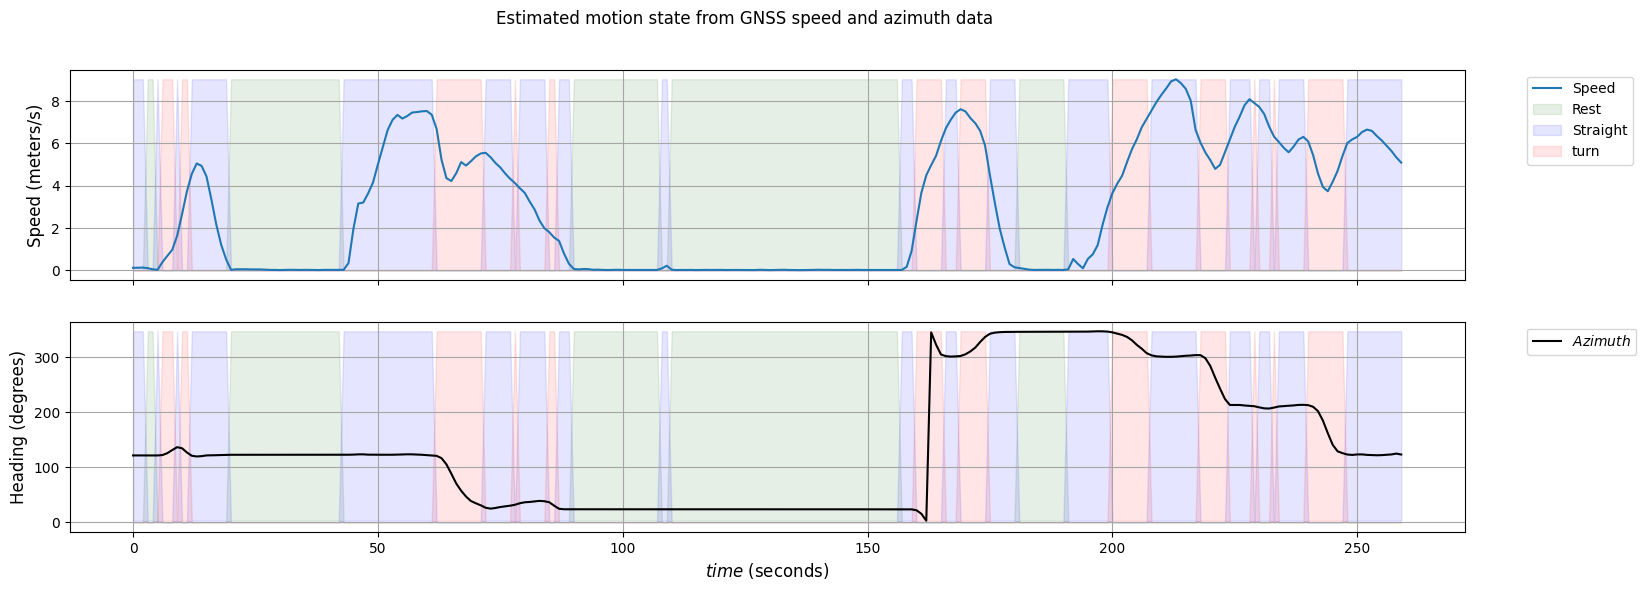

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,6), sharex='col')

max_spd, min_spd = max(df_gnss['speed']), min(df_gnss['speed'])
max_az, min_az = max(df_gnss['azimuth']), min(df_gnss['azimuth'])

axs[0].plot(df_gnss['t_rel'], df_gnss['speed'], label='Speed')


axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['rest'], max_spd*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['straight'], max_spd*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['turn'], max_spd*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[1].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['rest'], max_az*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['straight'],max_az*df_gnss['straight'], color='blue', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['turn'], max_az*df_gnss['turn'], color='red', alpha=0.1, )

fig.suptitle("Estimated motion state from GNSS speed and azimuth data")
axs[0].set_ylabel("Speed (meters/s)", size=12)
axs[1].set_ylabel("Heading (degrees)", size=12)
axs[1].set_xlabel(r'$time$ (seconds)', size=12)

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')        

### Data Labeling

These motion labels must be attached to the IMU datasets so that labeled features can be extracted. To do that IMU dataset is joined to the dataset on the UTC time second columns.<br>
This way all IMU data is linked to the GNSS data which it falls after (in time). 

In [36]:
imu_gnss = pd.merge(df_imu, 
                    df_gnss,
                    how='left',
                    left_on='time_sec',
                    right_on='time_sec',
                    suffixes=['_imu', '_gnss'],)

The right side of the dataset (GNSS side) represents the last GNSS measurement right before the current IMU data

In [37]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023987,31778097,-0.009424,0.009598,-0.007061,-0.000186,-0.075572,9.926544,1.031778,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
1,1.554024e+09,1554023987,41805028,-0.013273,-0.001445,-0.003336,0.242389,-0.133454,9.471782,1.041805,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
2,1.554024e+09,1554023987,51785945,-0.006775,0.001513,0.002580,0.418169,0.123401,9.704272,1.051786,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
3,1.554024e+09,1554023987,61822891,-0.008774,0.004429,-0.002785,0.161406,0.251727,10.097395,1.061823,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
4,1.554024e+09,1554023987,72040081,-0.009878,0.006944,-0.003777,-0.024371,0.079656,9.859933,1.072040,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0


In [38]:
# Ensure, no IMU data without GNSS based label
imu_gnss = imu_gnss[imu_gnss['time_ns_gnss'].notna()]
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023987,31778097,-0.009424,0.009598,-0.007061,-0.000186,-0.075572,9.926544,1.031778,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
1,1.554024e+09,1554023987,41805028,-0.013273,-0.001445,-0.003336,0.242389,-0.133454,9.471782,1.041805,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
2,1.554024e+09,1554023987,51785945,-0.006775,0.001513,0.002580,0.418169,0.123401,9.704272,1.051786,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
3,1.554024e+09,1554023987,61822891,-0.008774,0.004429,-0.002785,0.161406,0.251727,10.097395,1.061823,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0
4,1.554024e+09,1554023987,72040081,-0.009878,0.006944,-0.003777,-0.024371,0.079656,9.859933,1.072040,...,1.0,-183.692797,13.110181,-0.128723,0.114675,0.123314,121.44661,0.0,1.0,0.0


### Visualize the labeled IMU data, along with corresponding GNSS data used to make labels

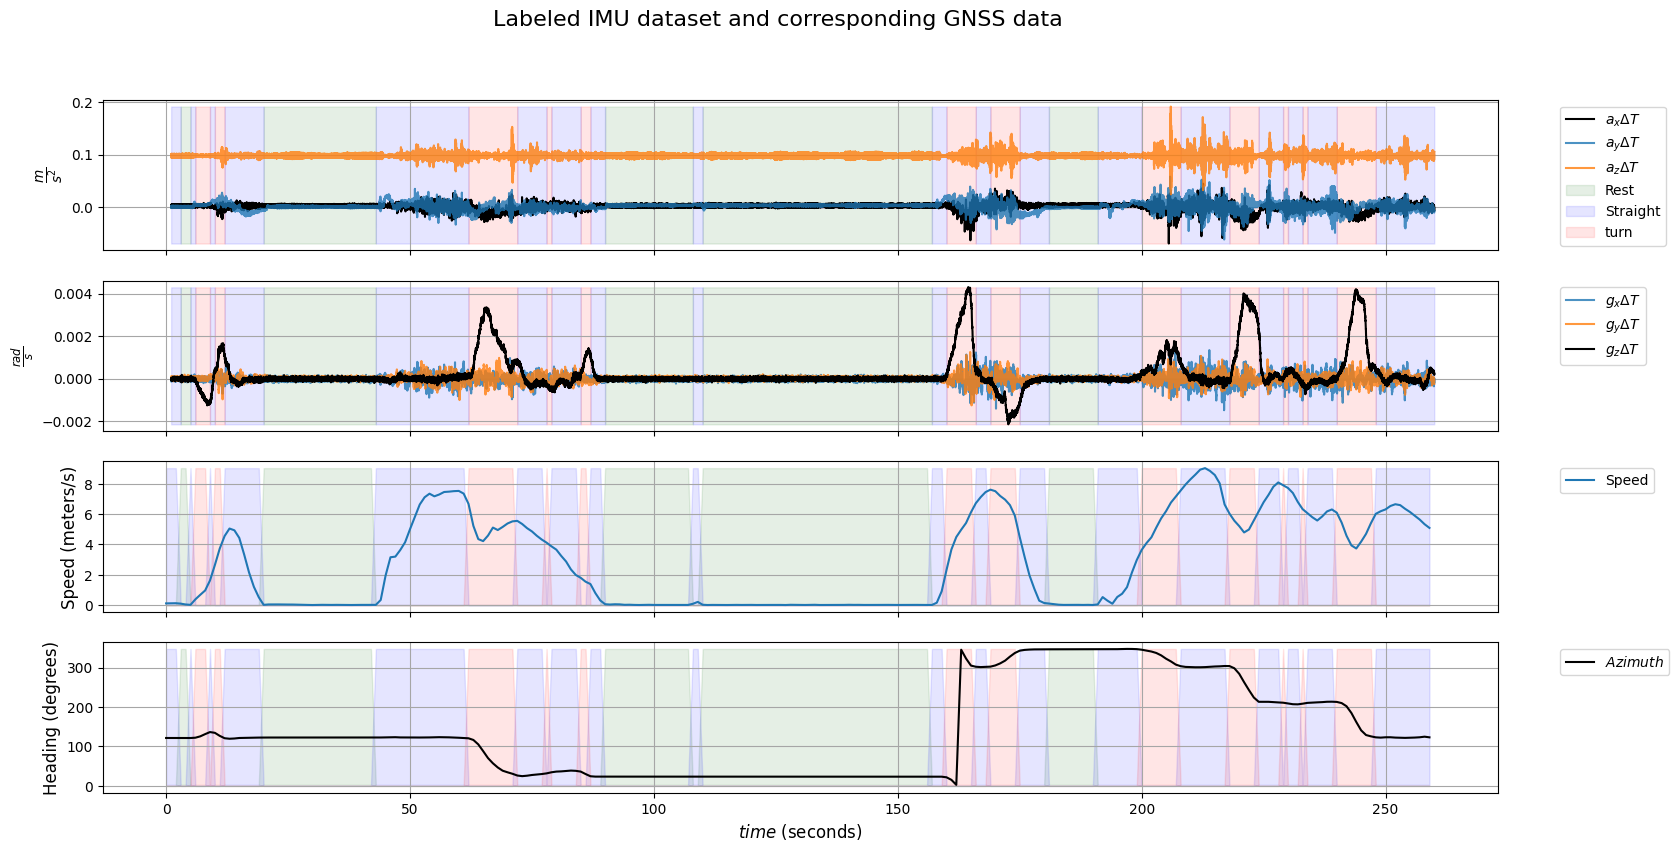

In [39]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9), sharex='col')

a_min, a_max = min(imu_gnss['axdt'].min(), imu_gnss['aydt'].min(), imu_gnss['azdt'].min()), max(imu_gnss['axdt'].max(), imu_gnss['aydt'].max(), imu_gnss['azdt'].max())
g_min, g_max = min(imu_gnss['gxdt'].min(), imu_gnss['gydt'].min(), imu_gnss['gzdt'].min()), max(imu_gnss['gxdt'].max(), imu_gnss['gydt'].max(), imu_gnss['gzdt'].max())

axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(imu_gnss['t_rel_imu'],imu_gnss['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['azdt'], label=r'$a_z \Delta T$', alpha=0.8)

axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['rest'], a_max*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['straight'], a_max*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['turn'],  a_max*imu_gnss['turn'], color='red', alpha=0.1, label='turn')


axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['rest'], g_max*imu_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['straight' ], g_max*imu_gnss['straight'], color='blue', alpha=0.1)
axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['turn'],  g_max*imu_gnss['turn'], color='red', alpha=0.1)


axs[2].plot(df_gnss['t_rel'], df_gnss['speed'], label='Speed')

axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['rest'], max_spd*df_gnss['rest'], color='darkgreen', alpha=0.1)
axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['straight'], max_spd*df_gnss['straight'], color='blue', alpha=0.1)
axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['turn'], max_spd*df_gnss['turn'], color='red', alpha=0.1)


axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['rest'], max_az*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['straight'],max_az*df_gnss['straight'], color='blue', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['turn'], max_az*df_gnss['turn'], color='red', alpha=0.1, )


fig.suptitle("Labeled IMU dataset and corresponding GNSS data", size=16)

axs[0].set_ylabel(r'$\frac{m}{s^2}$', size=14)
axs[1].set_ylabel(r'$\frac{rad}{s}$', size=12)

axs[2].set_ylabel("Speed (meters/s)", size=12)
axs[3].set_ylabel("Heading (degrees)", size=12)
axs[3].set_xlabel(r'$time$ (seconds)', size=12)

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')


### Features from IMU data 

Each window between GNSS data points has motion label. There are 100 IMU data points per window. <br>
It does not make sense to use 100 features to predict 1 label. <br>
Therefore, all IMU data points in each window are summarized using some statistics:
1. sum
2. min
3. max 
4. variance

These aggregate statistics are calculated using group-bys. All IMU datapoints in a window have the same GNSS-index (of the last GNSS data point in time). Group-bys are performed using these index.<br>

In [40]:
imu_window_sum = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].sum()
imu_window_sum.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
1.0,0.208844,0.078495,9.493337,-0.001675,0.001102,-0.001176,9.498792,0.008515
2.0,0.211935,0.086485,9.794426,-0.001977,0.000370,-0.000462,9.799902,0.008413
3.0,0.214289,0.083671,9.786784,-0.001740,0.000793,-0.001662,9.792245,0.009893
4.0,0.218394,0.083838,9.791271,-0.002218,0.001297,-0.001483,9.796759,0.009319
5.0,0.222900,0.259758,9.795122,-0.000059,0.001148,-0.001739,9.806574,0.009778


In [41]:
# Variance unaffected by data sign
imu_window_var = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].var()
imu_window_var.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
1.0,0.000004,0.000001,0.000006,3.856139e-09,2.467973e-09,1.958251e-09,0.000006,1.076465e-09
2.0,0.000004,0.000001,0.000007,3.463234e-09,2.769963e-09,1.785013e-09,0.000006,1.299795e-09
3.0,0.000004,0.000001,0.000007,3.881253e-09,3.281482e-09,3.870479e-09,0.000007,1.794662e-09
4.0,0.000004,0.000001,0.000008,3.439800e-09,3.309496e-09,2.681825e-09,0.000008,1.547565e-09
5.0,0.000003,0.000008,0.000006,5.623301e-09,2.478434e-09,2.738851e-09,0.000006,1.621392e-09


In [42]:
imu_window_min = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].min()
imu_window_min.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
1.0,-0.001163,-0.001541,0.093734,-0.000146,-0.000125,-0.000125,0.093785,0.000026
2.0,-0.001344,-0.001198,0.093958,-0.000152,-0.000117,-0.000107,0.094010,0.000015
3.0,-0.001497,-0.001143,0.093487,-0.000161,-0.000148,-0.000176,0.093513,0.000010
4.0,-0.001240,-0.001159,0.093441,-0.000175,-0.000121,-0.000160,0.093461,0.000017
5.0,-0.001856,-0.001659,0.093795,-0.000146,-0.000104,-0.000129,0.093818,0.000032


In [43]:
imu_window_max = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].max()
imu_window_max.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
1.0,0.005700,0.002976,0.101778,0.000119,0.000115,0.000103,0.101785,0.000171
2.0,0.005566,0.002930,0.101622,0.000137,0.000131,0.000090,0.101634,0.000167
3.0,0.005701,0.002926,0.101971,0.000110,0.000191,0.000181,0.101982,0.000219
4.0,0.005728,0.002998,0.102332,0.000101,0.000179,0.000102,0.102362,0.000206
5.0,0.005978,0.010632,0.102123,0.000207,0.000126,0.000130,0.102166,0.000213


In [44]:
# Labels from the GNSS data-set, and the index to connect to IMU features
df_labels = df_gnss[['gnss_index', 'rest', 'straight','turn']].copy()
df_labels.head()

,gnss_index,rest,straight,turn
0,0,0,1,0
1,1,0,1,0
2,2,0,1,0
3,3,1,0,0
4,4,1,0,0


In [45]:
# Add the featrues to labels
res_to_sffx = {
        '_sum': imu_window_sum,
        '_var': imu_window_var,
        '_min': imu_window_min,
        '_max': imu_window_max,
}
for key, _df in res_to_sffx.items():
    df_labels = pd.merge(
                left=df_labels,
                right=_df,
                left_on ='gnss_index',
                right_on='gnss_index',
                suffixes=[None, key]
    )

In [46]:
# This is the dataset consisting of labled features 
# Looks like _sum features did not get a suffixes
df_labels.head()

,gnss_index,rest,straight,turn,axdt,aydt,azdt,gxdt,gydt,gzdt,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,1,0,1,0,0.208844,0.078495,9.493337,-0.001675,0.001102,-0.001176,...,0.093785,0.000026,0.005700,0.002976,0.101778,0.000119,0.000115,0.000103,0.101785,0.000171
1,2,0,1,0,0.211935,0.086485,9.794426,-0.001977,0.000370,-0.000462,...,0.094010,0.000015,0.005566,0.002930,0.101622,0.000137,0.000131,0.000090,0.101634,0.000167
2,3,1,0,0,0.214289,0.083671,9.786784,-0.001740,0.000793,-0.001662,...,0.093513,0.000010,0.005701,0.002926,0.101971,0.000110,0.000191,0.000181,0.101982,0.000219
3,4,1,0,0,0.218394,0.083838,9.791271,-0.002218,0.001297,-0.001483,...,0.093461,0.000017,0.005728,0.002998,0.102332,0.000101,0.000179,0.000102,0.102362,0.000206
4,5,0,1,0,0.222900,0.259758,9.795122,-0.000059,0.001148,-0.001739,...,0.093818,0.000032,0.005978,0.010632,0.102123,0.000207,0.000126,0.000130,0.102166,0.000213


In [48]:
# Time window start and stop reference info (not needed, just for clarity)
df_labels['gnss_index_start'] = df_labels['gnss_index'].copy()
df_labels['gnss_index_end'] = df_labels['gnss_index_start'] + 1

In [49]:
df_labels.head()

,gnss_index,rest,straight,turn,axdt,aydt,azdt,gxdt,gydt,gzdt,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1,0,1,0,0.208844,0.078495,9.493337,-0.001675,0.001102,-0.001176,...,0.005700,0.002976,0.101778,0.000119,0.000115,0.000103,0.101785,0.000171,1,2
1,2,0,1,0,0.211935,0.086485,9.794426,-0.001977,0.000370,-0.000462,...,0.005566,0.002930,0.101622,0.000137,0.000131,0.000090,0.101634,0.000167,2,3
2,3,1,0,0,0.214289,0.083671,9.786784,-0.001740,0.000793,-0.001662,...,0.005701,0.002926,0.101971,0.000110,0.000191,0.000181,0.101982,0.000219,3,4
3,4,1,0,0,0.218394,0.083838,9.791271,-0.002218,0.001297,-0.001483,...,0.005728,0.002998,0.102332,0.000101,0.000179,0.000102,0.102362,0.000206,4,5
4,5,0,1,0,0.222900,0.259758,9.795122,-0.000059,0.001148,-0.001739,...,0.005978,0.010632,0.102123,0.000207,0.000126,0.000130,0.102166,0.000213,5,6


In [50]:
# Add _sum suffixes and create the final labeled featuers data-set which is almost ready for supervising learning
rename_map = {}
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'a', 'g']:
    rename_map[col+'dt'] = col+'dt_sum'

df_results = df_labels.rename(rename_map, axis=1).copy()
df_results.head()

,gnss_index,rest,straight,turn,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1,0,1,0,0.208844,0.078495,9.493337,-0.001675,0.001102,-0.001176,...,0.005700,0.002976,0.101778,0.000119,0.000115,0.000103,0.101785,0.000171,1,2
1,2,0,1,0,0.211935,0.086485,9.794426,-0.001977,0.000370,-0.000462,...,0.005566,0.002930,0.101622,0.000137,0.000131,0.000090,0.101634,0.000167,2,3
2,3,1,0,0,0.214289,0.083671,9.786784,-0.001740,0.000793,-0.001662,...,0.005701,0.002926,0.101971,0.000110,0.000191,0.000181,0.101982,0.000219,3,4
3,4,1,0,0,0.218394,0.083838,9.791271,-0.002218,0.001297,-0.001483,...,0.005728,0.002998,0.102332,0.000101,0.000179,0.000102,0.102362,0.000206,4,5
4,5,0,1,0,0.222900,0.259758,9.795122,-0.000059,0.001148,-0.001739,...,0.005978,0.010632,0.102123,0.000207,0.000126,0.000130,0.102166,0.000213,5,6


In [51]:
# The dummy variable representation of motion state was good for plotting here,
# however, its better for ML to summarize motion state in one column
def motion_state_str(row: pd.Series) -> str:
    if row['rest']:
        return 'rest'
    if row['straight']:
        return 'straight'
    if row['turn']:
        return 'turn'

In [52]:
df_results['motion_state'] = df_results.apply(lambda x: motion_state_str(x), axis=1)

Aggregate statistics which are affected by the sign of the signal, i.e., sum,min,max of the x,y,z components are not considered. 

In [53]:
feature_target_cols = 'motion_state,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max'.split(',')
feature_target_cols 

['motion_state',
 'adt_sum',
 'gdt_sum',
 'axdt_var',
 'aydt_var',
 'azdt_var',
 'gxdt_var',
 'gydt_var',
 'gzdt_var',
 'adt_var',
 'gdt_var',
 'adt_min',
 'gdt_min',
 'adt_max',
 'gdt_max']

In [54]:
# Write to labeled-features dataset to CSV 
df_results[feature_target_cols].to_csv('data/training.csv', index=False)